# Predicting House Prices
### Kritesh Shrestha and David Yen
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

The objective of this project is to predict housing prices in the test data be training on the train data. We will start by doing a bit of EDA and selecting key features; we will be creating a linear regression model as our baseline.

In [ ]:
##Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_squared_log_error, mean_absolute_error
from google.colab import drive
drive.mount('/content/drive')

np.random.seed()

Mounted at /content/drive


# Part 1: Base Line

## EDA/ Feature Selection

In [ ]:
#Train and test data
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
#train = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Our train data has a total of 79 features to choose from. To avoid overfitting, we will try to choose features that are highly correlated with our Y-value (SalesPrice).

In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Our test data is missing the price as we will be using our model to predict the price for the test data. In order to understand the accuracy of our predictions we will have to split our training data to a train and dev set.

In [ ]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


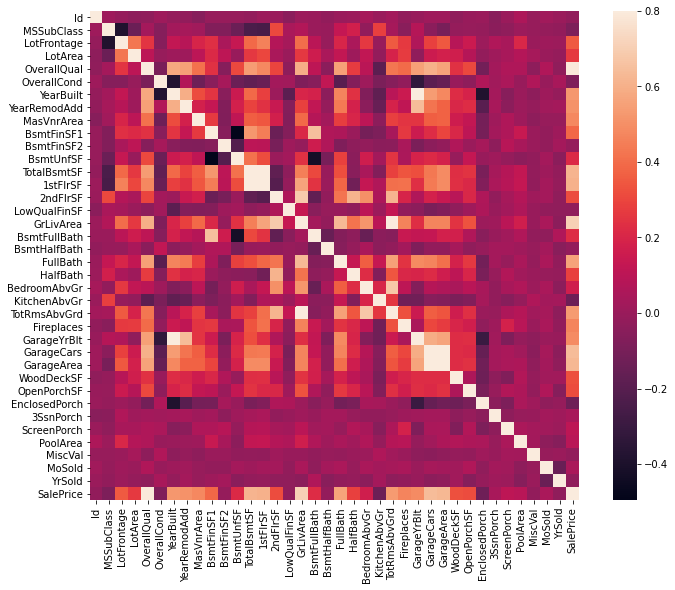

In [ ]:
#correlation matrix
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

Using the correlation matrix we can better select features for our inital model. We will be selecting features that are highly correlated with our model, more specifically we will be selecting the top 10 features with the highest correlation.

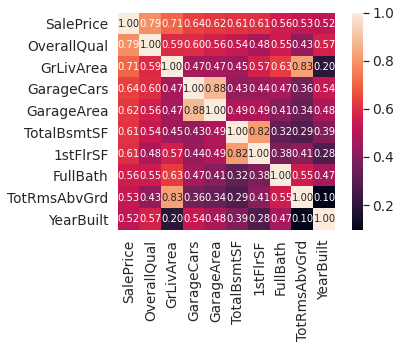

In [ ]:
#Choosing top 10 from the correlation matrix
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

It seems as though the following will be the features for our models.
- OverallQaul, Rates the overall material and finish of the house.
- GrlivArea, Above grade (ground) living area square feet.
- GarageCars, Size of garage in car capacity.
- GarageArea, Size of garage in square feet.
- TotalBsmtSF, Total square feet of basement area.
- 1stFlrSF, First floor square feet.
- Fullbath, Full bathrooms above grade.
- TotRmsAbvGrd, Total rooms above grade (does not include bathrooms).
- YearBuilt, Original construction date.

### Missing Values
In this section we will be addressing missing values.

In [ ]:
#missing data, creating total sum of missing values
total = train.isnull().sum().sort_values(ascending=False)
#creating a percentage of those missing values
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


To be safe we will remove any variable with more than one observation that is missing.

In [ ]:
#removing any variables that are missing more than one observation
remove_vars = (missing_data[missing_data['Total'] > 1]).index
train = train.drop(remove_vars,axis=1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train = train[['OverallQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt','SalePrice']]

In [ ]:
train.shape

(1459, 9)

Next we will split the training data to a train set and dev set.

In [ ]:
print("data shape", train.shape)

data shape (1459, 9)


In [ ]:
#splitting train to train and dev
train, dev = train_test_split(train, test_size=0.2, random_state=1)

In [ ]:
print('data shape train: ', train.shape)
print('data shape dev: ', dev.shape)

data shape train:  (1167, 9)
data shape dev:  (292, 9)


In [ ]:
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
X_dev = dev.drop(['SalePrice'],axis=1)
y_dev = dev['SalePrice']

## First Model: Baseline (Linear Regression) and Metric of Evaluation (R-Squared)


In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)

print("R-Squared: ", model.score(X_train,y_train))
print("Adj R-Squared:", 1-(1-model.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-train.shape[1]-1))

y_predict = model.predict(X_dev)
print('MAE: ',mean_absolute_error(y_dev,y_predict))
print('MAPE: ',mean_absolute_error(y_dev/y_dev,y_predict/y_dev))
print('RMSE:',np.sqrt(mean_squared_error(y_dev, y_predict)))

R-Squared:  0.7565655846078411
Adj R-Squared: 0.7546719720421284
MAE:  24102.017029692674
MAPE:  0.15726570933307135
RMSE: 31550.42399123208


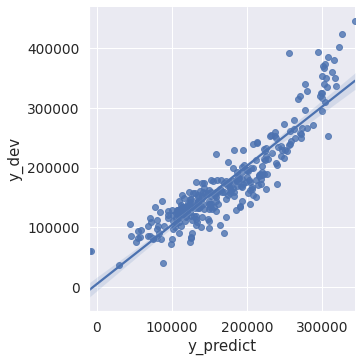

In [ ]:
pred_df = pd.DataFrame({'y_dev': y_dev, 'y_predict': y_predict})
sns.lmplot(x='y_predict',y = 'y_dev',data=pred_df)

We pick R-Squared as our metric of evaluation since it provides a good measure for how much of the variance observed in the sale price is predictable from our model.  In this case, our R-Squared value tells our model explains about 74% of the difference in house prices. While this not bad for our first model, we believe we can futher improve on it by data tranformations, additional feature engineering, and normalizing our features.

Going forward we will be choosing a different algorithm due to a key failure to of linear regression model to handle string based features. We left out features such as HouseStyle and BldgeType which could have been good features towards our prediction.

# Part 2: Additional EDA and Feature Engineering
Given the preliminary work in Part 1, we have a basic understanding of the data and have developed a baseline linear regressions model for the top 10 highly correlated predictors (input variables) and the target (output) variable, 'SalePrice'. We used a 80/20 split to divide our training data into 80% train and 20% dev data and found our baseline linear regression model resulted in a R-squared value of 74-76%.  

In Part 2 of this project, we intend to explore deeper into the dataset and perform feature engineering to clean up, transform and normalize the input data and try to understand the impact of an expanded set of features, combination of features, or new features on the accuracy of our model prediction by employing advanced machine learning techniques from this class like K-Nearest Neighbors and Random Forest.  

To measure our model performance, in addition to R-squared, we will also look into other measures of goodness-of-fit and accuracy metrics like RMSE (root mean square error), MAE (mean absolute error), MAPE (mean absolute percent error), RMSLE (root mean square log error), and RMSPE (root mean square percent error) so that we can compare our results with other well-known benchmarks like Zillow's Zestimate in model performance.  

In terms of modeling strategy, we would like to employ mostly supervised learning techniques and continue to divide our training data into train and dev sets so we can take advantage of the known sale prices to tune the hyperparameters and prevent overfitting.  To achieve the best house price prediction accuracy, we expect many of the advanced ML methods, like Random Forest, Support Vector Machines and Gradient Boosting Regressors would perform well but we also want to have good explanability for the model, so attention will be paid to compare the ML methods with various robust Regression methods.  We also want to understand the effects of intrinsic features like total square footage and number of rooms in the house and extrinsic features like location, time of sale and community/neighborhood that are influential to the sale price but only circumstantial to the house.  Finding explicit relationships between these intrinsic and extrinsic driving factors will help generalize the model and yield superior model performance beyond the given train and test data sets.

### Check-in and final project plan

Email to me: shuri@berkeley.edu 

subject: Final Project Check-in: team member list: 
- Kritesh Shrestha & David Yen

What was done so far: what did you do, what was harder than you expected, challenges you overcame, methods and techniques you applied from class.

- Given the preliminary work in Part 1, we have a basic understanding of the data and a baseline performance of a simple linear regressions model with the top 10 highly correlated predictors (input variables) and the target (output) variable, 'SalePrice'. We used a 80/20 split to divide our training data into 80% train and 20% dev data and found our baseline linear regression model resulted in a R-squared value of 74-76%. 
- We also did a broad survey of the literature to understand the state-of-the-art methods used in house price prediction and used that to set the scope and approach of our project and also to benchmark the model performance.
- The condition of the raw data and the number of features in the dataset are a bit overwhelming so serious feature engineering and generalizable model design are the biggest challenges we face.
- The hardest part of the challenge we see is in making the last percent of improvement especially generalizable performance improvement for unseen data or markets.
- Intuitively, we could divide the features into two categories, one set of house intrinsic variables and the other set of extrinsic variables.  We could assemble them together with a pipeline to improve the ensemble model performance and help generalization of the model to different markets and datasets.

What you still plan to do.
- Deeper feature engineering with combination of features and new features; also data preprocessing, transformation and cleaning
- Additional performance metrics: RMSE, RMSLE, RMSPE, MAE, MAPE, and adj R2 = 1-(1-R2)*(n-1)/(n-p-1), where p is number of independent variables and n is number of data samples
- Comparing model performance with ML methods and robust Regression methods applied to intrinsic house features and external environmental features

What challenges do you anticipate.
- Fine-grained features (such as luxury level of the house or neighborhood) that are not included in the dataset may have a huge influence on the target variable (sale price).  Many recent papers use vision based approaches that try to supplement the traditional text based data with satellite images of the neighborhood, or interior images of the house to improve prediction accuracy, but that is outside the scope of this project.  However, our ensemble modeling (with intrinsic and extrinsic features) architecture hopefully can be easily expanded to include additional vision based data if so desired. 

### Here's a brief version of what you'll find in the data description file.

* t SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* c<-n MSSubClass: The building class
* e_c MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property; na<-median(LotConfig, MSZoning, neighborhood, knn)
* LotArea: Lot size in square feet
* e_c Street: Type of road access; 12/2919 == grvl
* e_c Alley: Type of alley access; 120/2919 == grvl
* c LotShape: General shape of property
* c LandContour: Flatness of the property
* c Utilities: Type of utilities available; na<-0, !AllPub<-0
* c LotConfig: Lot configuration
* c LandSlope: Slope of property
* e_c Neighborhood: Physical locations within Ames city limits
* e_c Condition1: Proximity to main road or railroad
* e_c Condition2: Proximity to main road or railroad (if a second is present)
* c BldgType: Type of dwelling
* c HouseStyle: Style of dwelling
* l OverallQual: Overall material and finish quality
* l OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* c RoofStyle: Type of roof
* c RoofMatl: Roof material
* c Exterior1st: Exterior covering on house
* c Exterior2nd: Exterior covering on house (if more than one material)
* c MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* l<-o ExterQual: Exterior material quality
* l<-o ExterCond: Present condition of the material on the exterior
* c Foundation: Type of foundation
* n<-o BsmtQual: Height of the basement
* l<-o BsmtCond: General condition of the basement
* l<-o BsmtExposure: Walkout or garden level basement walls
* l<-o BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* l<-o BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* c Heating: Type of heating
* l<-o HeatingQC: Heating quality and condition
* b CentralAir: Central air conditioning
* c Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* l<-o KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* l<-o Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* l<-o FireplaceQu: Fireplace quality
* c GarageType: Garage location
* GarageYrBlt: Year garage was built
* l<-o GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* l<-o GarageQual: Garage quality
* l<-o GarageCond: Garage condition
* c PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* l<-o PoolQC: Pool quality
* c Fence: Fence quality; no fence is better than gd privacy, min wd/wi worse
* c MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: Value of miscellaneous feature
* e MoSold: Month Sold
* e YrSold: Year Sold
* e_c SaleType: Type of sale
* e_c SaleCondition: Condition of sale

$$e: extrinsic, c: categorical, l: Likert-scale , b: binary, n: numeric, t: target, o: object$$

In [ ]:
#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
quantitative = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

print("There are total of ", len(quantitative), "quantitative features besides 'Id' and 'SalePrice'.\n \nThese features are:")
print(quantitative)

print("\nThere are total of ", len(qualitative), "qualitative features.\n \nThese features are:")
print(qualitative)

There are total of  38 quantitative features besides 'Id' and 'SalePrice'.
 
These features are:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

There are total of  43 qualitative features.
 
These features are:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure'

In [ ]:
from datetime import datetime
from scipy.stats import skew, boxcox_normmax, norm, probplot  
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
# from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
import scipy.stats as stats
import math
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_squared_log_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


## Exploratory Data Analysis

In [ ]:
X_df = train_df.drop(['SalePrice'], axis=1)
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
#all_df = pd.concat([train_df],sort=False).reset_index(drop=True)

### Sale Price Distribution in the Training Dataset

In [ ]:
from scipy.stats import probplot

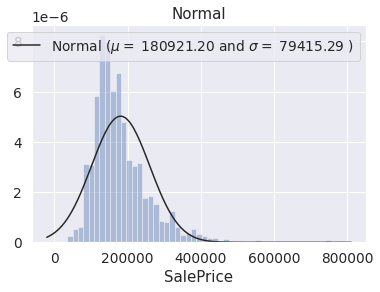

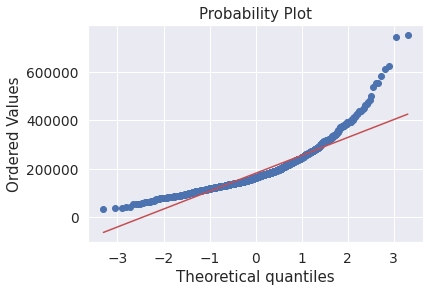

In [ ]:
y_df = train_df['SalePrice']

plt.figure(1); plt.title('Normal')
sns.distplot(y_df, kde=False, fit=stats.norm)
mu, sigma = stats.norm.fit(y_df)
plt.legend(['Normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')

plt.figure(2); plt.title('qqplot')
qq = probplot(y_df, plot=plt);

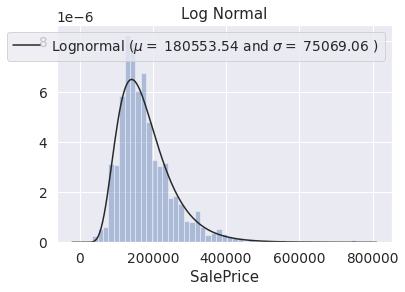

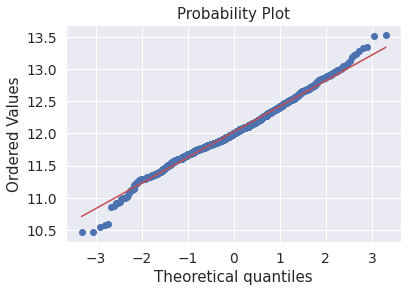

In [ ]:
log1p_y = np.log1p(train_df['SalePrice'])
mu_ly, sigma_ly = stats.norm.fit(log1p_y)
mu_ln = np.exp(mu_ly+.5*sigma_ly**2)
sigma_ln = mu_ln * ((np.exp(sigma_ly**2))-1)**.5

plt.figure(); plt.title('Log Normal')
sns.distplot(y_df, kde=False, fit=stats.lognorm)
plt.legend(['Lognormal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_ln, sigma_ln)], loc = 'best');

plt.figure(); plt.title('Log transformed qqplot')
qq2 = probplot(log1p_y, plot=plt);

The histogram of SalePrice suggests that the distribution is skewed and a log transformation of the target variable makes a much better fit than a normal distribution.  The standard deviation of a lognormal distribution, shown in the legends of the above plot, is smaller than that of a  normal distribution, signifying a tighter fit to the underlyingf data.  But at the both ends of the spectrum, there are still outliers that have much larger variations than a single lognormal distribution can adquately represent.

In part 1, we have demonstrated that the linear regression model with the 10 most correlated predictor variables to the target variable, sale price, yielded a linear multivariate model that has a R-squared value of roughly 75%.  In other word, the model was able to explain about 75% of the variation in the training data. In the following, we will explore the missing data, fill in the blanks by triangulation from existing data or educated quesses and engineer additional features that help explain the target variable better by exploiting as much as possible useful information contained in the data.

In [ ]:
all_df.shape
all_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,...,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,...,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


In [ ]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### Missing Data in both the Training and the Test Datasets

A quick look at the dataframe shows that there are a lot of missing data in both the training and the test datasets. Many variables are also closely linked, for example, there are 11 variables related to 'basement' and 7 variables related to 'garage'. We may be able to piece together some of the missing data from the information contained in other related variables.

In [ ]:
print(X_df.info())
print(test_df.info())
print(all_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Study the Impacts of Individual Variables on Sale Price and Explore the Fill-in Strategies for Missing Data 

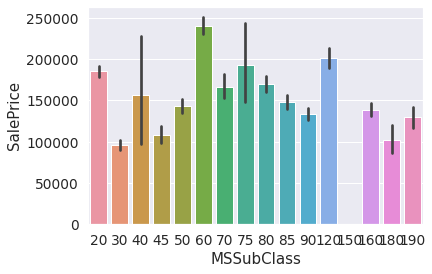

In [ ]:
sns.barplot(x='MSSubClass',y = 'SalePrice',data=all_df)

In [ ]:
msz_na = all_df["MSZoning"].isnull()
all_df.loc[msz_na]

#all_df['MSZoning'] = all_df['MSZoning'].fillna(all_df['MSZoning'].mode()[0])
all_df['MSZoning'] = all_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_df[msz_na]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,...,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RL,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,...,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,...,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,...,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN


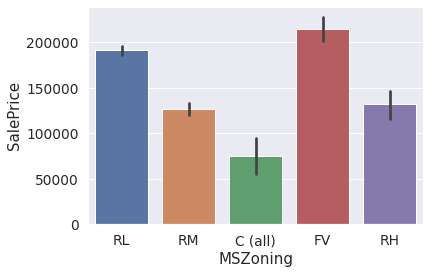

In [ ]:
sns.barplot(x='MSZoning',y = 'SalePrice',data=all_df)

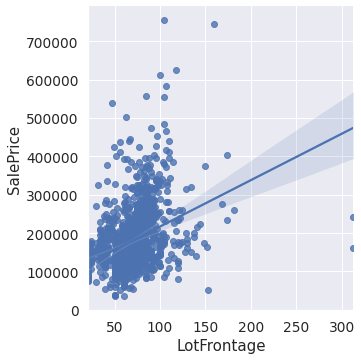

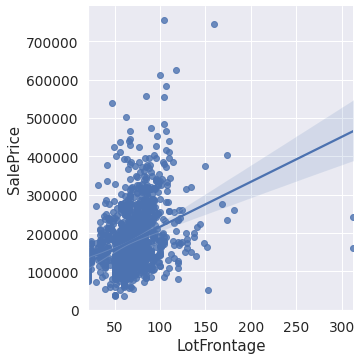

In [ ]:
lotf_na = all_df["LotFrontage"].isnull()
#print(all_df.loc[lotf_na])
sns.lmplot(x='LotFrontage',y = 'SalePrice',data=train_df)
all_df['LotFrontage'] = all_df.groupby('LotConfig')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
#print(all_df[lotf_na])
sns.lmplot(x='LotFrontage',y = 'SalePrice',data=all_df)

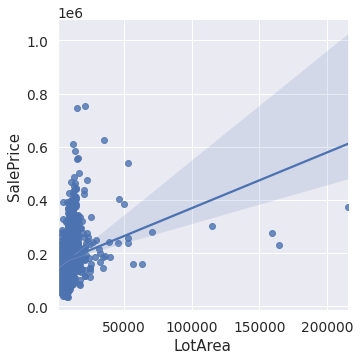

In [ ]:
sns.lmplot(x='LotArea',y = 'SalePrice',data=all_df)

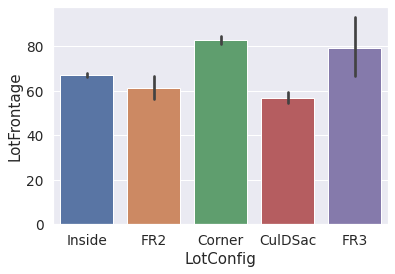

In [ ]:
sns.barplot(x='LotConfig',y = 'LotFrontage',data=all_df)

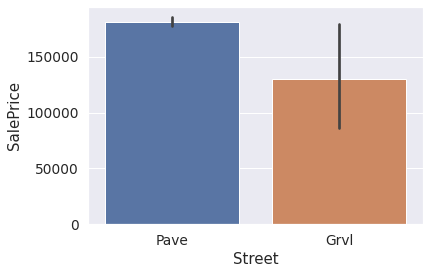

In [ ]:
sns.barplot(x='Street',y = 'SalePrice',data=all_df)

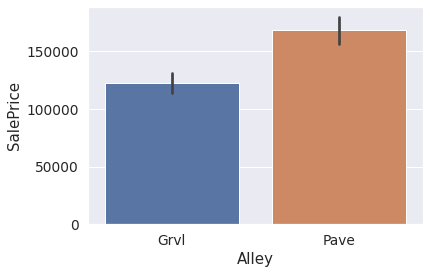

In [ ]:
sns.barplot(x='Alley',y = 'SalePrice',data=all_df)

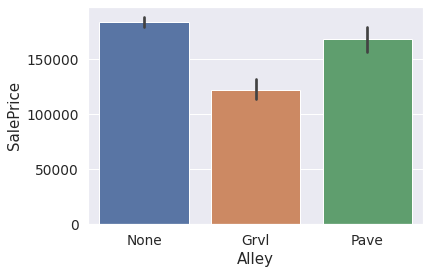

In [ ]:
all_df['Alley'] = all_df['Alley'].fillna('None')
sns.barplot(x='Alley',y = 'SalePrice',data=all_df)

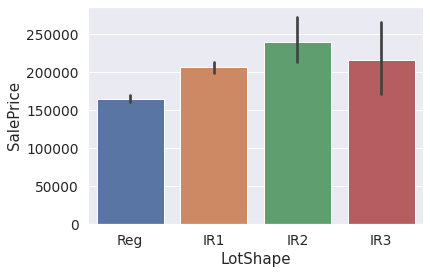

In [ ]:
sns.barplot(x='LotShape',y = 'SalePrice',data=all_df)

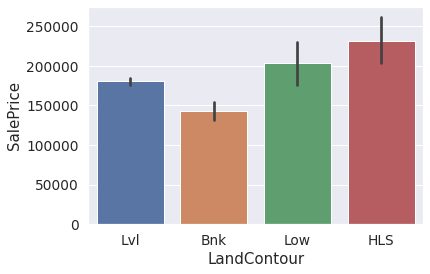

In [ ]:
sns.barplot(x='LandContour',y = 'SalePrice',data=all_df)

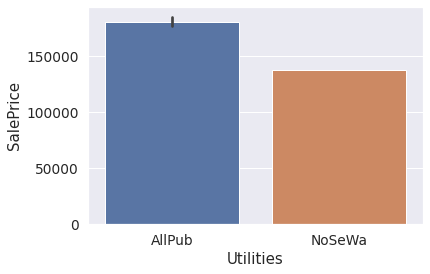

In [ ]:
sns.barplot(x='Utilities',y = 'SalePrice',data=all_df)

In [ ]:
all_df[all_df['Utilities']!='AllPub']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
944,945,20,RL,56.775281,14375,Pave,None,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,1Fam,SLvl,6,6,1958,1958,Gable,CompShg,HdBoard,HdBoard,BrkFace,541.0,TA,TA,CBlock,TA,TA,No,GLQ,111.0,Rec,354.0,354.0,819.0,GasA,...,Y,FuseA,1344,0,0,1344,0.0,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Basment,1958.0,RFn,2.0,525.0,TA,TA,Y,0,118,0,0,233,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500.0
1915,1916,30,RM,109.000000,21780,Grvl,None,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,...,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,NaN
1945,1946,20,RL,61.276923,31220,Pave,None,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,...,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NaN,NaN,Shed,750,5,2008,WD,Normal,NaN


In [ ]:
all_df['Utilities'] = all_df['Utilities'].fillna('AllPub')

In [ ]:
#all_df.iloc[[944, 1915, 1945]]
all_df.iloc[[944]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
944,945,20,RL,56.775281,14375,Pave,None,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,1Fam,SLvl,6,6,1958,1958,Gable,CompShg,HdBoard,HdBoard,BrkFace,541.0,TA,TA,CBlock,TA,TA,No,GLQ,111.0,Rec,354.0,354.0,819.0,GasA,...,Y,FuseA,1344,0,0,1344,0.0,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Basment,1958.0,RFn,2.0,525.0,TA,TA,Y,0,118,0,0,233,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500.0


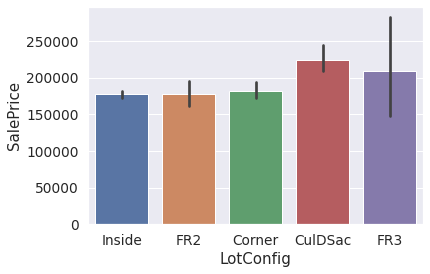

In [ ]:
sns.barplot(x='LotConfig',y = 'SalePrice',data=all_df)

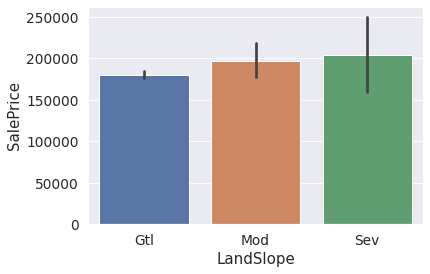

In [ ]:
sns.barplot(x='LandSlope',y = 'SalePrice',data=all_df)

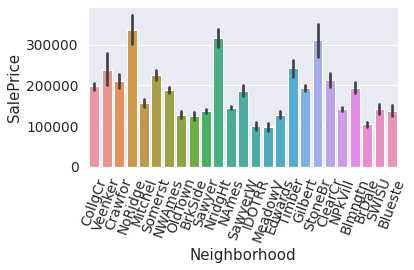

In [ ]:
sns.barplot(x='Neighborhood',y = 'SalePrice',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

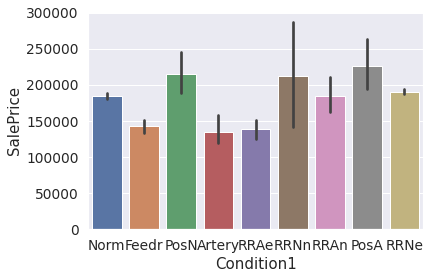

In [ ]:
sns.barplot(x='Condition1',y = 'SalePrice',data=all_df)

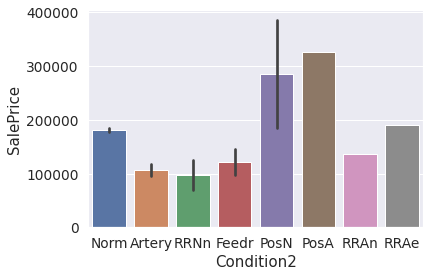

In [ ]:
sns.barplot(x='Condition2',y = 'SalePrice',data=all_df)

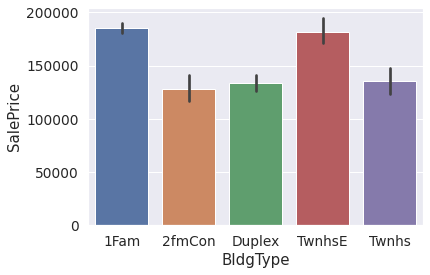

In [ ]:
sns.barplot(x='BldgType',y = 'SalePrice',data=all_df)

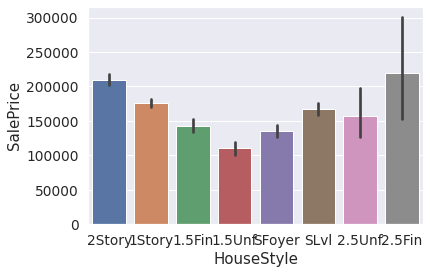

In [ ]:
sns.barplot(x='HouseStyle',y = 'SalePrice',data=all_df)

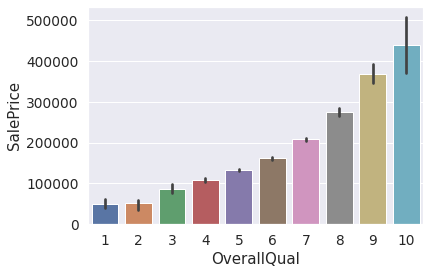

In [ ]:
sns.barplot(x='OverallQual',y = 'SalePrice',data=all_df)

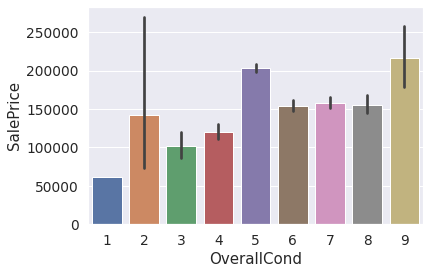

In [ ]:
sns.barplot(x='OverallCond',y = 'SalePrice',data=all_df)

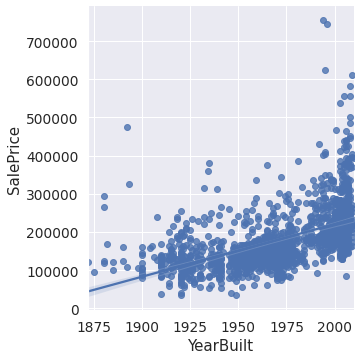

In [ ]:
sns.lmplot(x='YearBuilt',y = 'SalePrice',data=all_df)

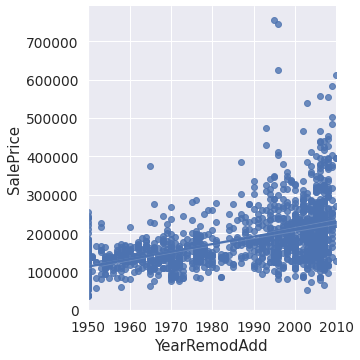

In [ ]:
sns.lmplot(x='YearRemodAdd',y = 'SalePrice',data=all_df)

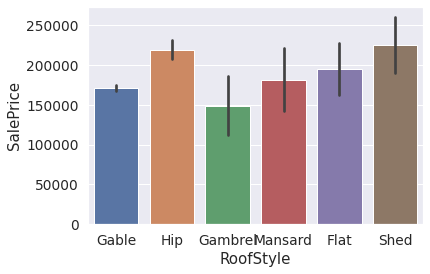

In [ ]:
sns.barplot(x='RoofStyle',y = 'SalePrice',data=all_df)

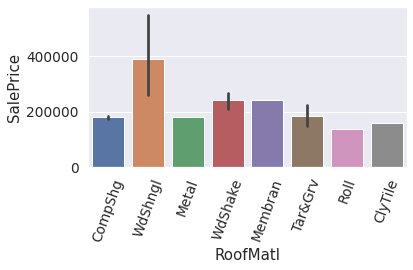

In [ ]:
sns.barplot(x='RoofMatl',y = 'SalePrice',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

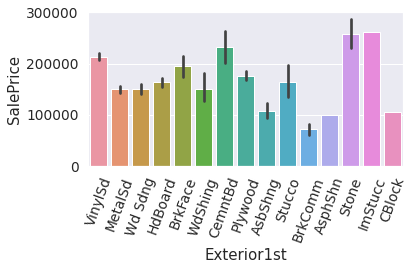

In [ ]:
sns.barplot(x='Exterior1st',y = 'SalePrice',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

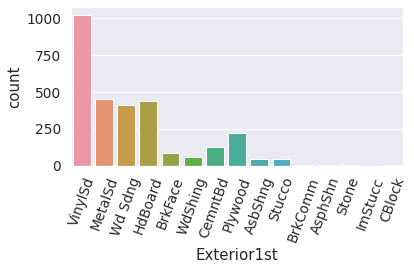

In [ ]:
sns.countplot(x='Exterior1st',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

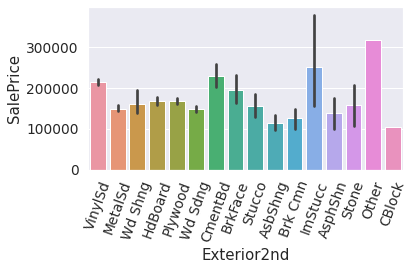

In [ ]:
sns.barplot(x='Exterior2nd',y = 'SalePrice',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

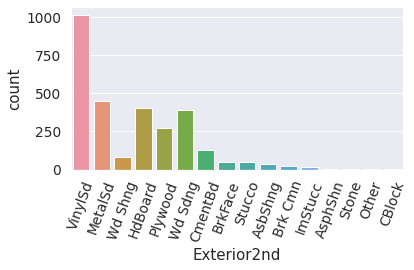

In [ ]:
sns.countplot(x='Exterior2nd',data=all_df)
plt.xticks(rotation=70)
plt.tight_layout()

In [ ]:
all_df[all_df['Exterior1st'].isnull()]

all_df[all_df['Exterior2nd'].isnull()]

all_df['Exterior1st'] = all_df['Exterior1st'].fillna(all_df['Exterior1st'].mode()[0]) 
all_df['Exterior2nd'] = all_df['Exterior2nd'].fillna(all_df['Exterior2nd'].mode()[0])
#all_df.loc[2151]

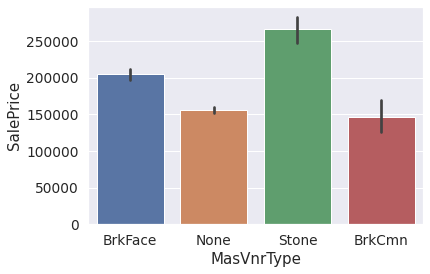

In [ ]:
sns.barplot(x='MasVnrType',y = 'SalePrice',data=all_df)

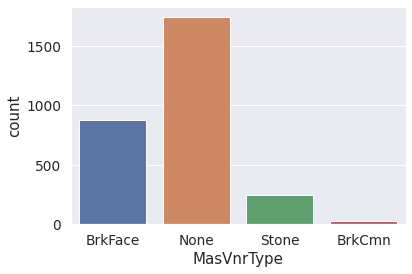

In [ ]:
sns.countplot(x='MasVnrType',data=all_df)

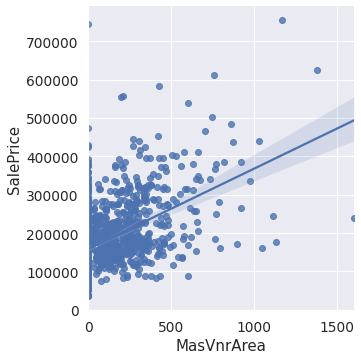

In [ ]:
sns.lmplot(x='MasVnrArea',y = 'SalePrice',data=all_df)

In [ ]:
all_df[all_df['MasVnrArea'].isnull()]

all_df[all_df['MasVnrType'].isnull()] 

all_df[(all_df['MasVnrType'].isnull() ^ all_df['MasVnrArea'].isnull())].fillna(all_df['MasVnrType'].mode()[0])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2610,2611,20,RL,124.0,27697,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,None,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,...,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,None,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,None,None,None,0,11,2007,COD,Abnorml,None


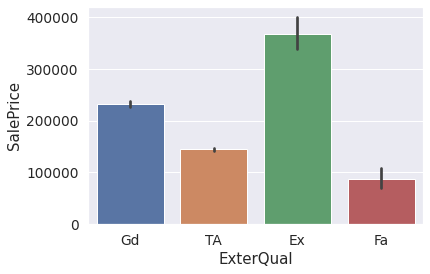

In [ ]:
sns.barplot(x='ExterQual',y = 'SalePrice',data=all_df)

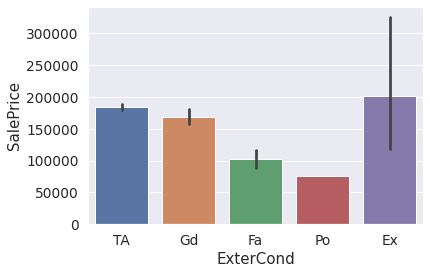

In [ ]:
sns.barplot(x='ExterCond',y = 'SalePrice',data=all_df)

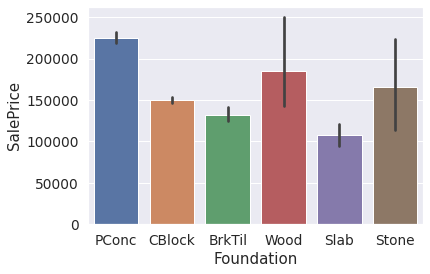

In [ ]:
sns.barplot(x='Foundation',y = 'SalePrice',data=all_df)

In [ ]:
all_df[all_df['BsmtFinType1'].isnull()].shape

all_df[(all_df['BsmtFinType2'].isnull() ^ all_df['BsmtFinType1'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,GasA,...,Y,SBrkr,1629,0,0,1629,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3.0,880.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000.0


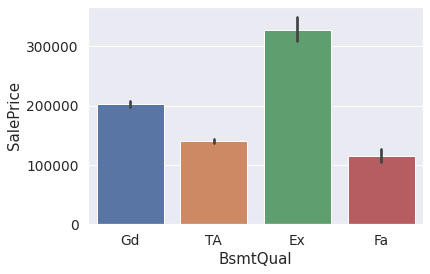

In [ ]:
sns.barplot(x='BsmtQual',y='SalePrice',data=all_df)

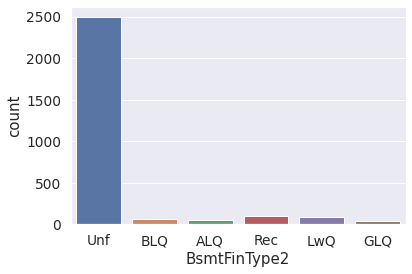

In [ ]:
sns.countplot(x='BsmtFinType2',data=all_df)

In [ ]:
all_df.iloc[332].fillna(all_df['BsmtFinType2'].mode(1)[0])[30:44]

all_df.loc[332,'BsmtFinType2'] = 'Rec'
all_df.iloc[332, 31:44]

BsmtCond           TA
BsmtExposure       No
BsmtFinType1      GLQ
BsmtFinSF1       1124
BsmtFinType2      Rec
BsmtFinSF2        479
BsmtUnfSF        1603
TotalBsmtSF      3206
Heating          GasA
HeatingQC          Ex
CentralAir          Y
Electrical      SBrkr
1stFlrSF         1629
Name: 332, dtype: object

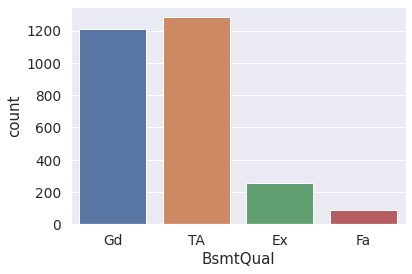

In [ ]:
sns.countplot(x='BsmtQual',data=all_df)

In [ ]:
all_df[(all_df['BsmtQual'].isnull() ^ all_df['BsmtFinType1'].isnull())]

#all_df[(all_df['BsmtQual'].isnull() ^ all_df['BsmtFinType1'].isnull())].fillna(all_df['BsmtQual'].mode()[0], inplace=True)

#all_df.loc[[2217,2218], 'BsmtQual'] = 'TA'
#all_df.iloc[2217:2219, 30:50]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2217,2218,70,C (all),60.0,5280,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,...,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,NaN
2218,2219,50,C (all),52.0,5150,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,...,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,NaN


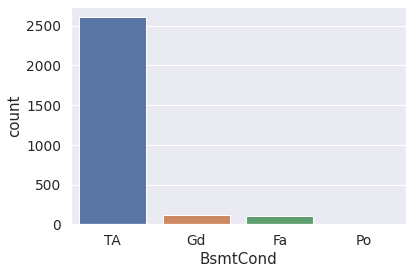

In [ ]:
sns.countplot(x='BsmtCond',data=all_df)

In [ ]:
all_df[(all_df['BsmtCond'].isnull() ^ all_df['BsmtFinType1'].isnull())]


all_df[(all_df['BsmtCond'].isnull() ^ all_df['BsmtFinType1'].isnull())].BsmtCond = 'TA'

#all_df[(all_df['BsmtCond'].isnull() ^ all_df['BsmtFinType1'].isnull())].BsmtCond.fillna('TA')
#all_df.loc[[2040,2185,2524], 'BsmtCond'] = 'TA'
#all_df.iloc[[2040,2185,2524], 30:50]

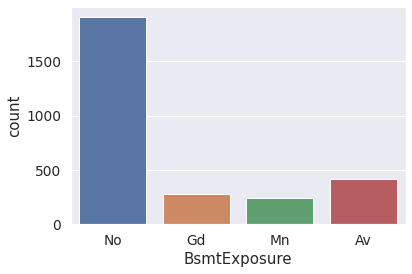

In [ ]:
sns.countplot(x='BsmtExposure',data=all_df)

In [ ]:
all_df[(all_df['BsmtExposure'].isnull() ^ all_df['BsmtFinType1'].isnull())]

#all_df.loc[[948,1487,2348],'BsmtExposure'] = 'No'
#all_df.iloc[[948,1487,2348], 30:50]

all_df.loc[[948],'BsmtExposure'] = 'No'
all_df.iloc[[948], 30:50]

all_df[all_df['BsmtFullBath'].isnull()].iloc[:,30:50]

#all_df.loc[[2120,2188],['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = 0
#all_df.iloc[[2120,2188], 30:51]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1
2188,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3


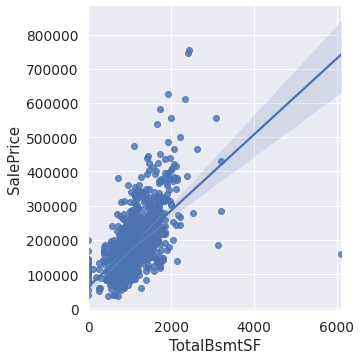

In [ ]:
sns.lmplot(x='TotalBsmtSF',y='SalePrice',data=all_df)

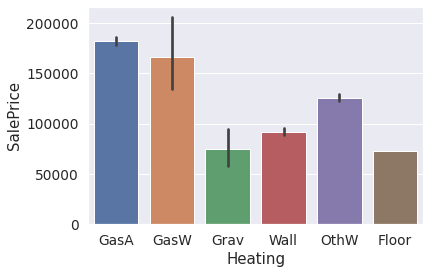

In [ ]:
sns.barplot(x='Heating',y='SalePrice',data=all_df)

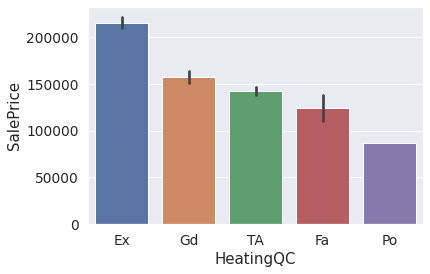

In [ ]:
sns.barplot(x='HeatingQC',y='SalePrice',data=all_df)

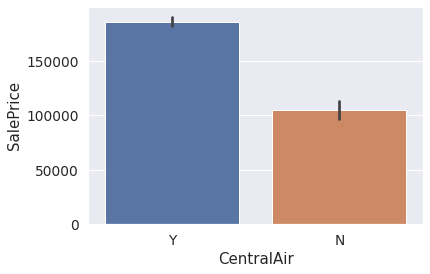

In [ ]:
sns.barplot(x='CentralAir',y='SalePrice',data=all_df)

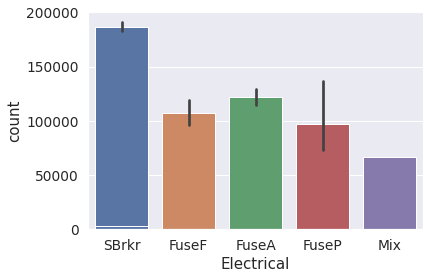

In [ ]:
sns.barplot(x='Electrical',y = 'SalePrice',data=all_df)

sns.countplot(x='Electrical',data=all_df)

all_df[all_df['Electrical'].isnull()]

all_df['Electrical'] = all_df['Electrical'].fillna('SBrkr')

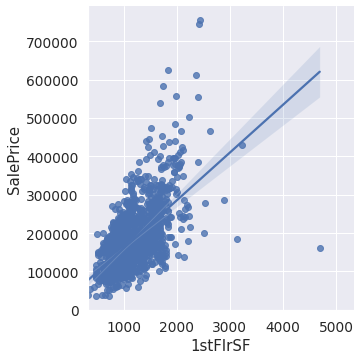

In [ ]:
sns.lmplot(x='1stFlrSF',y='SalePrice',data=all_df)

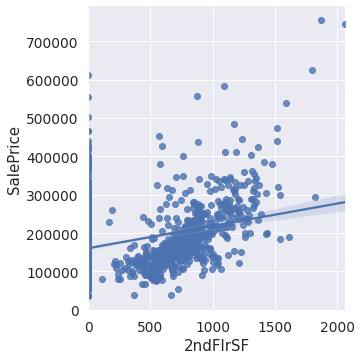

In [ ]:
sns.lmplot(x='2ndFlrSF',y='SalePrice',data=all_df)

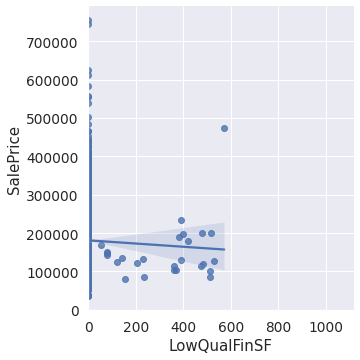

In [ ]:
sns.lmplot(x='LowQualFinSF',y='SalePrice',data=all_df)

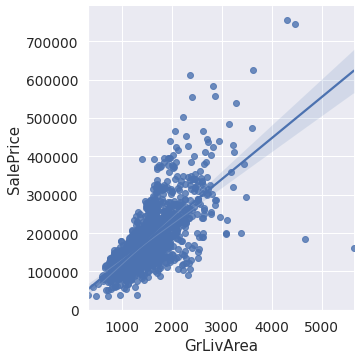

In [ ]:
sns.lmplot(x='GrLivArea',y='SalePrice',data=all_df)

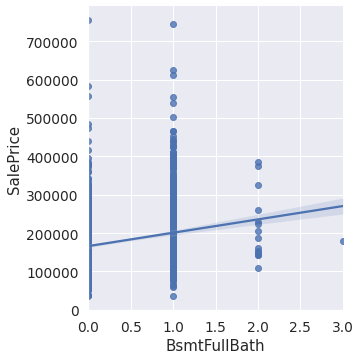

In [ ]:
sns.lmplot(x='BsmtFullBath',y='SalePrice',data=all_df)

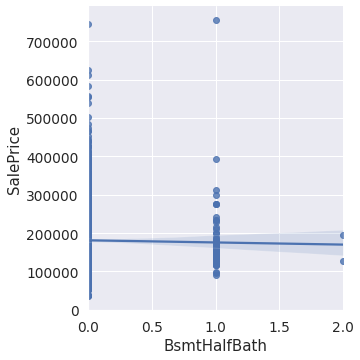

In [ ]:
sns.lmplot(x='BsmtHalfBath',y='SalePrice',data=all_df)

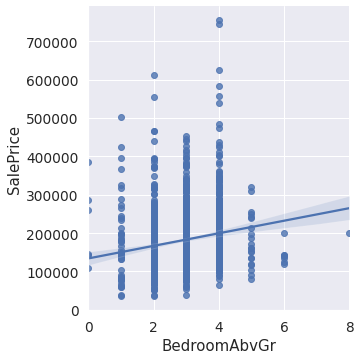

In [ ]:
sns.lmplot(x='BedroomAbvGr',y='SalePrice',data=all_df)

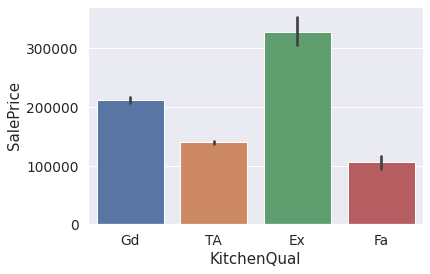

In [ ]:
sns.barplot(x='KitchenQual',y='SalePrice',data=all_df)

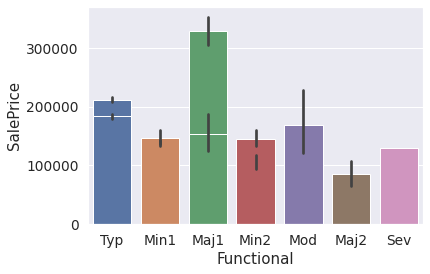

In [ ]:
all_df[all_df['KitchenQual'].isnull()]

all_df['KitchenQual'] = all_df['KitchenQual'].fillna(all_df['KitchenQual'].mode()[0])

#all_df.loc[1555,'KitchenQual']

sns.barplot(x='KitchenQual',y = 'SalePrice',data=all_df)

sns.countplot(x='KitchenQual',data=all_df)

sns.barplot(x='Functional',y = 'SalePrice',data=all_df)

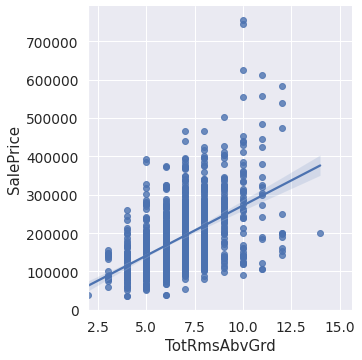

In [ ]:
sns.lmplot(x='TotRmsAbvGrd',y='SalePrice',data=all_df)

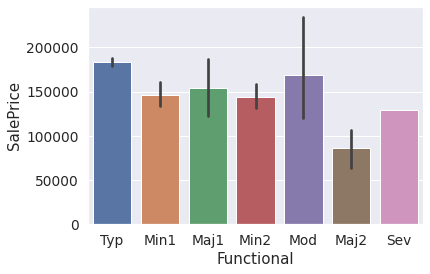

In [ ]:
sns.barplot(x='Functional',y = 'SalePrice',data=all_df)

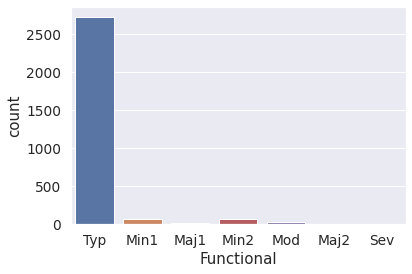

In [ ]:
sns.countplot(x='Functional',data=all_df)

In [ ]:
all_df[all_df['Functional'].isnull()]

all_df['Functional'] = all_df['Functional'].fillna(all_df['Functional'].mode()[0])

#all_df.loc[[2216,2473],'Functional']

all_df['FireplaceQu'].isnull().sum()

len(all_df[all_df['Fireplaces']==0])

all_df['FireplaceQu'] = all_df['FireplaceQu'].fillna('None')

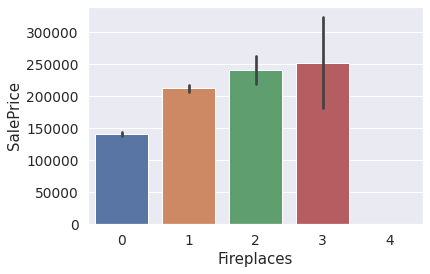

In [ ]:
sns.barplot(x='Fireplaces',y = 'SalePrice',data=all_df)

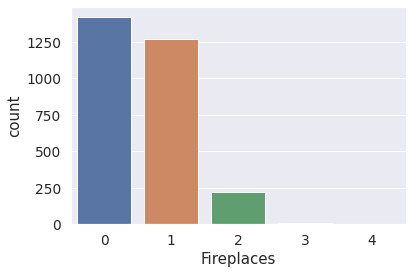

In [ ]:
sns.countplot(x='Fireplaces',data=all_df)

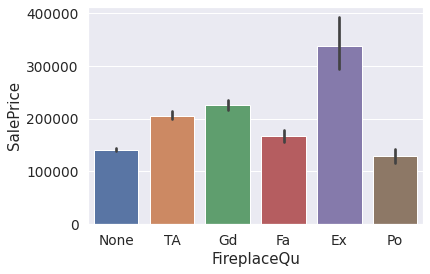

In [ ]:
sns.barplot(x='FireplaceQu',y = 'SalePrice',data=all_df)

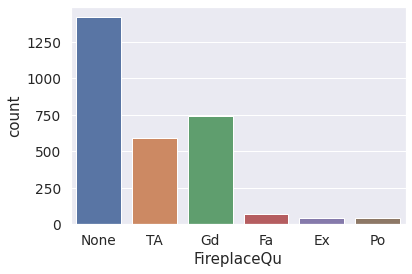

In [ ]:
sns.countplot(x='FireplaceQu',data=all_df)

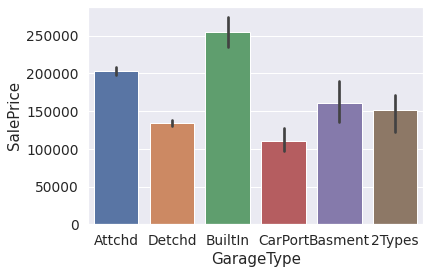

In [ ]:
sns.barplot(x='GarageType',y='SalePrice',data=all_df)

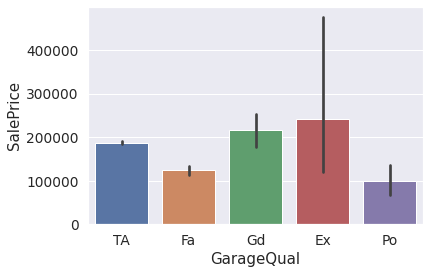

In [ ]:
sns.barplot(x='GarageQual',y='SalePrice',data=all_df)

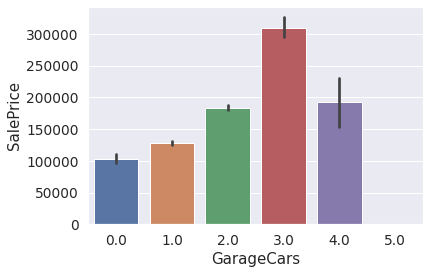

In [ ]:
sns.barplot(x='GarageCars',y='SalePrice',data=all_df)

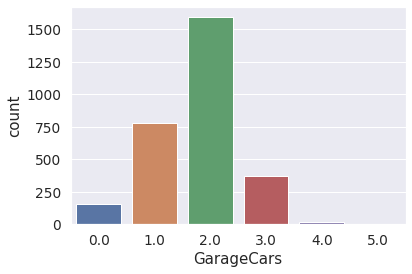

In [ ]:
sns.countplot(x='GarageCars',data=all_df)

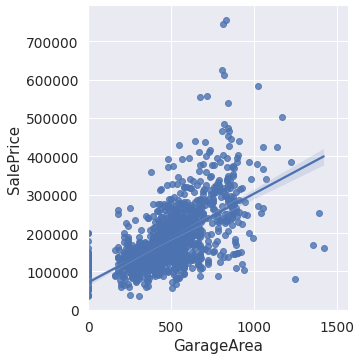

In [ ]:
sns.lmplot(x='GarageArea',y='SalePrice',data=all_df)

In [ ]:
print('The shape of null GarageType data frame is: ', all_df[all_df['GarageType'].isnull()].shape)
print('The shape of null GarageCars data frame is: ', all_df[all_df['GarageCars'].isnull()].shape)
print('The shape of null GarageArea data frame is: ', all_df[all_df['GarageArea'].isnull()].shape)
print('The shape of null GarageQual data frame is: ', all_df[all_df['GarageQual'].isnull()].shape)
print('The shape of null GarageCond data frame is: ', all_df[all_df['GarageCond'].isnull()].shape)
print('The shape of null GarageFinish data frame is: ', all_df[all_df['GarageFinish'].isnull()].shape)
print('The shape of null GarageYrBlt data frame is: ', all_df[all_df['GarageYrBlt'].isnull()].shape)
print('The shape of null YearRemodAdd data frame is: ', all_df[all_df['YearRemodAdd'].isnull()].shape)

The shape of null GarageType data frame is:  (157, 81)
The shape of null GarageCars data frame is:  (1, 81)
The shape of null GarageArea data frame is:  (1, 81)
The shape of null GarageQual data frame is:  (159, 81)
The shape of null GarageCond data frame is:  (159, 81)
The shape of null GarageFinish data frame is:  (159, 81)
The shape of null GarageYrBlt data frame is:  (159, 81)
The shape of null YearRemodAdd data frame is:  (0, 81)


In [ ]:
# Based on the missing data information above, we know that there are 157 houses with no garage.  In addition, there is one 
# house with no GarageCars and GarageArea information and 2 houses lack GarageQual, GarageCond, GarageYrBlt and GarageFinish data.
# Based on the information below, it is apparent that ID:2127 has a garage and we could fillna with median or mode dada in 
# the respective feature.
all_df[(all_df['GarageCond'].isnull() ^ all_df['GarageType'].isnull())].iloc[:,19:66]

,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive
2126,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y
2576,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y


In [ ]:
l=all_df.filter(["GarageFinish","GarageQual","GarageCond"]).mode()
#all_df.loc[2126,["GarageFinish","GarageQual","GarageCond"]]=all_df.loc[2126,["GarageFinish","GarageQual","GarageCond"]].fillna(value=l.iloc[0])
#all_df.loc[2126,"GarageYrBlt"]=all_df.loc[2126,"YearRemodAdd"]
#print(all_df.iloc[2126,19:66])

In [ ]:
# For ID:2577, since no garage at all the GarageType needs to be set to 'NaN', and ["GarageCars","GarageArea"]=0
#all_df.loc[2576,["GarageType","GarageFinish","GarageQual","GarageCond"]]='NaN'
#all_df.loc[2576,["GarageCars","GarageArea"]]=0
#print(all_df.iloc[2576,19:66])

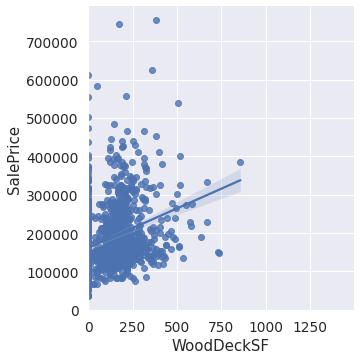

In [ ]:
sns.lmplot(x='WoodDeckSF',y = 'SalePrice',data=all_df)

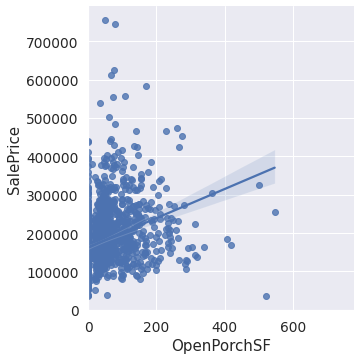

In [ ]:
sns.lmplot(x='OpenPorchSF',y = 'SalePrice',data=all_df)

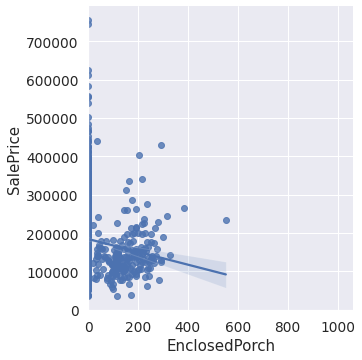

In [ ]:
sns.lmplot(x='EnclosedPorch',y = 'SalePrice',data=all_df)

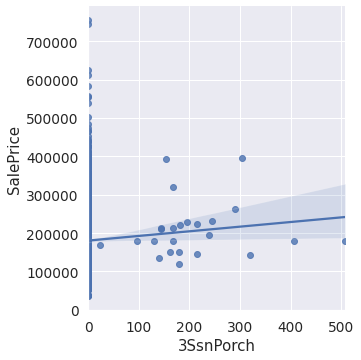

In [ ]:
sns.lmplot(x='3SsnPorch',y = 'SalePrice',data=all_df)

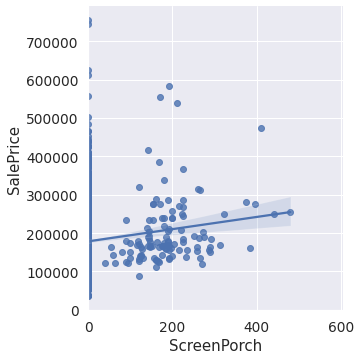

In [ ]:
sns.lmplot(x='ScreenPorch',y = 'SalePrice',data=all_df)

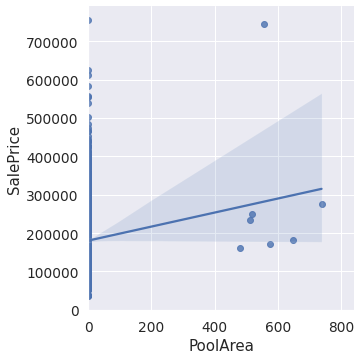

In [ ]:
sns.lmplot(x='PoolArea',y = 'SalePrice',data=all_df)

In [ ]:
poolqc_nna = all_df[all_df['PoolArea']>0]

In [ ]:
poolqc_nna

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.000000,25419,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,...,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000.0
810,811,20,RL,78.000000,10140,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,...,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000.0
1170,1171,80,RL,76.000000,9880,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,...,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000.0
1182,1183,60,RL,160.000000,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,...,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000.0
1298,1299,60,RL,313.000000,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,...,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000.0
1386,1387,60,RL,80.000000,16692,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,...,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000.0
1423,1424,80,RL,56.775281,19690,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,...,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970.0
1974,1975,20,RL,106.000000,12720,Pave,None,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,...,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal,NaN
2420,2421,20,RL,75.000000,9532,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,...,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,M

In [ ]:
all_df.loc[poolqc_nna[poolqc_nna['PoolQC'].isnull()].index, 'PoolQC'] = 'Gd'

In [ ]:
#print(all_df.iloc[[2420, 2503, 2599]])

In [ ]:
#print(all_df.iloc[[2420, 2503, 2599]])
#print(all_df.loc[2420])
#print(all_df.loc[2503])
#print(all_df.loc[2599])

In [ ]:
#print(all_df[poolqc_nna['PoolQC'].isnull()])
print(poolqc_nna['PoolQC'].isnull)

<bound method Series.isnull of 197      Ex
810      Fa
1170     Gd
1182     Ex
1298     Gd
1386     Fa
1423     Gd
1974     Ex
2420    NaN
2503    NaN
2573     Ex
2599    NaN
2710     Gd
Name: PoolQC, dtype: object>


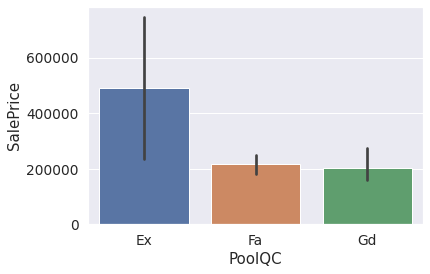

In [ ]:
sns.barplot(x='PoolQC',y = 'SalePrice',data=poolqc_nna)
#print(all_df.loc[poolqc_nna])

#all_df['SaleType'] = all_df.groupby('SaleCondition')['SaleType'].transform(lambda x: x.fillna(x.mode()[0]))
#print(all_df[salet_na])

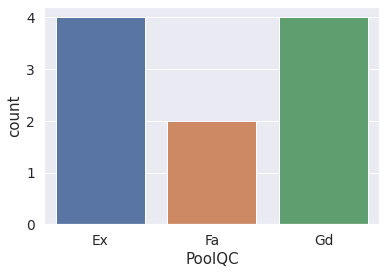

In [ ]:
sns.countplot(x='PoolQC',data=poolqc_nna)


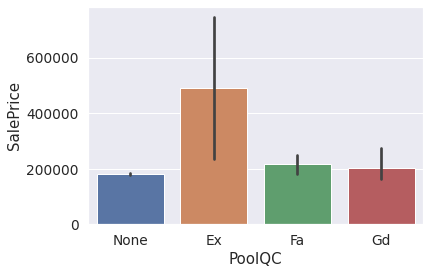

In [ ]:
all_df['PoolQC'] = all_df['PoolQC'].fillna('None')
sns.barplot(x='PoolQC',y = 'SalePrice',data=all_df)

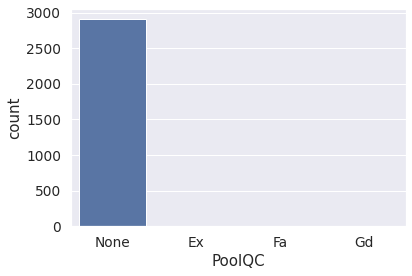

In [ ]:
sns.countplot(x='PoolQC',data=all_df)

In [ ]:
all_df['Fence'] = all_df['Fence'].fillna('None')

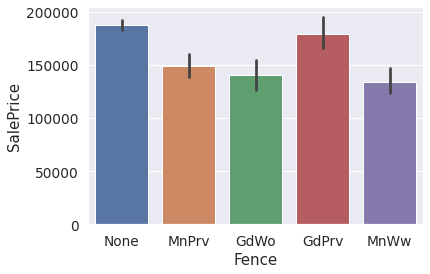

In [ ]:
sns.barplot(x='Fence',y = 'SalePrice',data=all_df)

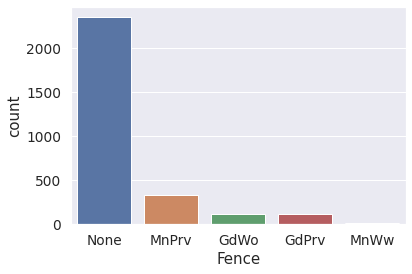

In [ ]:
sns.countplot(x='Fence',data=all_df)

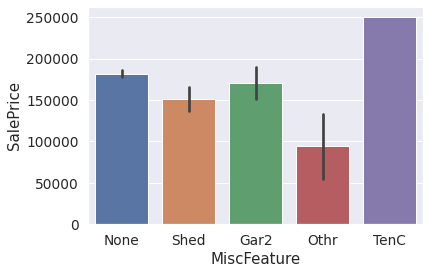

In [ ]:
all_df['MiscFeature'] = all_df['MiscFeature'].fillna('None')
sns.barplot(x='MiscFeature',y = 'SalePrice',data=all_df)

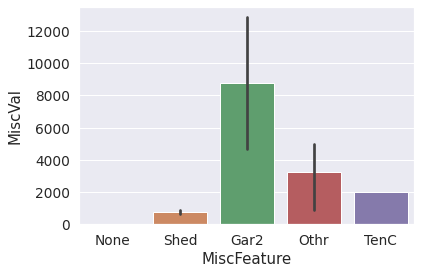

In [ ]:
sns.barplot(x='MiscFeature',y = 'MiscVal',data=all_df)

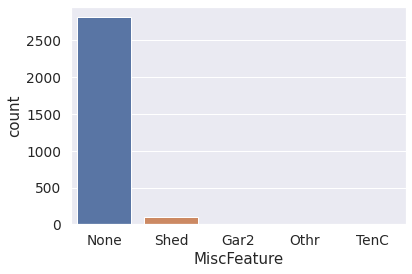

In [ ]:
sns.countplot(x='MiscFeature',data=all_df)


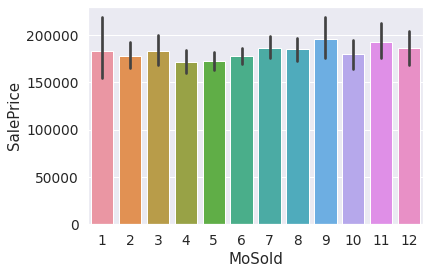

In [ ]:
sns.barplot(x='MoSold',y = 'SalePrice',data=all_df)

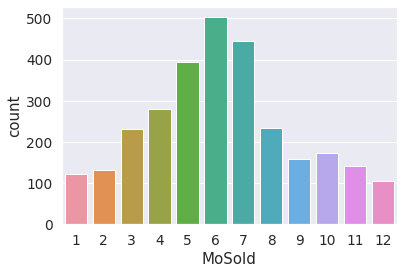

In [ ]:
sns.countplot(x='MoSold',data=all_df)

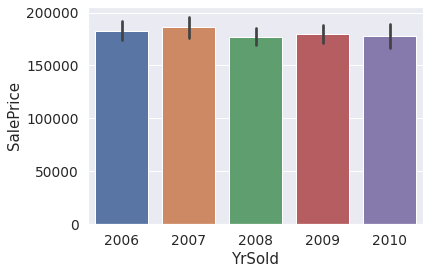

In [ ]:
sns.barplot(x='YrSold',y = 'SalePrice',data=all_df)

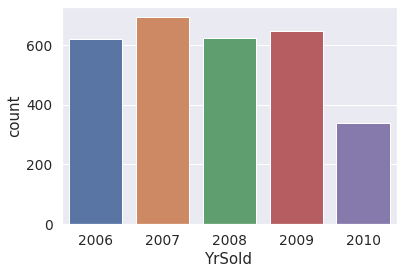

In [ ]:
sns.countplot(x='YrSold',data=all_df)

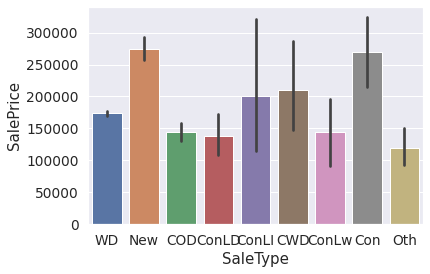

In [ ]:
sns.barplot(x='SaleType',y = 'SalePrice',data=all_df)

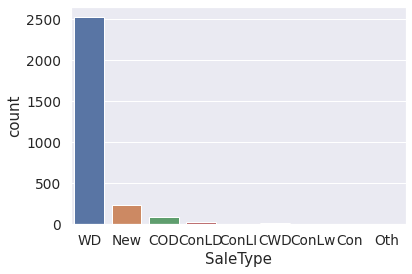

In [ ]:
sns.countplot(x='SaleType',data=all_df)

In [ ]:
salet_na = all_df["SaleType"].isnull()
print(all_df.loc[salet_na])

#all_df['SaleType'] = all_df.groupby('SaleCondition')['SaleType'].transform(lambda x: x.fillna(x.mode()[0]))

        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
2489  2490          20       RL  ...       NaN         Normal       NaN

[1 rows x 81 columns]


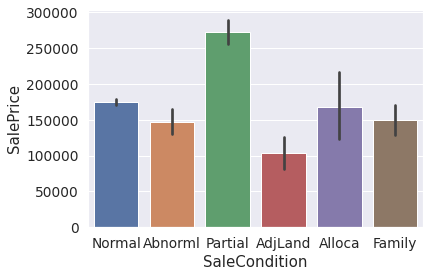

In [ ]:
sns.barplot(x='SaleCondition',y = 'SalePrice',data=all_df)

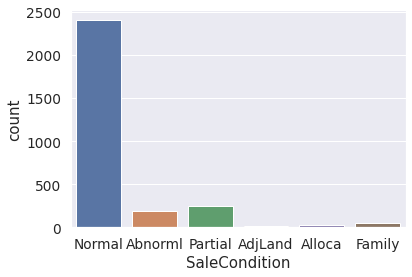

In [ ]:
sns.countplot(x='SaleCondition',data=all_df)

In [ ]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0


## Prepare the Dataset for Regression Analysis with Additional Feature Engineering

In [ ]:
# Make MSSubClass a categorical variable. The raw data type for this variable is integer but it is really not intended 
# to be a continuous numerical variable and best be represented as categorical in the final analysis
all_df['MSSubClass'] = all_df['MSSubClass'].apply(str)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [ ]:
all_df.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,69.172913,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,21.592895,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,67.205693,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [ ]:
#divide data into object and numerics
objects = []
for i in all_df.columns:
    if all_df[i].dtype == object:
        objects.append(i)
all_df.update(all_df[objects].fillna('None'))

numeric_dtypes = ['int64', 'float64']
numerics = []
for i in all_df.columns:
    if all_df[i].dtype in numeric_dtypes:
        numerics.append(i)
all_df.update(all_df[numerics].fillna(0))

In [ ]:
#adjustment to features
all_df = all_df.drop(['Utilities', 'Street', 'PoolQC','SalePrice'], axis=1)

all_df['YrBltAndRemod']=all_df['YearBuilt']+all_df['YearRemodAdd']
all_df['TotalSF']=all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']

all_df['Total_sqr_footage'] = (all_df['BsmtFinSF1'] + all_df['BsmtFinSF2'] +
                                 all_df['1stFlrSF'] + all_df['2ndFlrSF'])

all_df['Total_Bathrooms'] = (all_df['FullBath'] + (0.5 * all_df['HalfBath']) +
                               all_df['BsmtFullBath'] + (0.5 * all_df['BsmtHalfBath']))

all_df['Total_porch_sf'] = (all_df['OpenPorchSF'] + all_df['3SsnPorch'] +
                              all_df['EnclosedPorch'] + all_df['ScreenPorch'] +
                              all_df['WoodDeckSF'])


In [ ]:
all_df['haspool'] = all_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['has2ndfloor'] = all_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['hasgarage'] = all_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['hasbsmt'] = all_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['hasfireplace'] = all_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Add Dummy Features to the Predictor Matrix for Categorical Variables

In [ ]:
# add dummy features for categorical variables
ad_all = pd.get_dummies(all_df).reset_index(drop=True)
ad_all.shape

(2919, 321)

In [ ]:
ad_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 321 entries, Id to SaleCondition_Partial
dtypes: float64(14), int64(32), uint8(275)
memory usage: 1.8 MB


### Set the 'Id' Column as Index and Split the Data Matrix into Training and Test sets

In [ ]:
y = y_df

X = ad_all.iloc[:len(y), :]
X.set_index('Id', inplace=True)

X_test = ad_all.iloc[len(y):, :]
X_test.set_index('Id', inplace=True)
X.shape, y.shape, X_test.shape

((1460, 320), (1460,), (1459, 320))

In [ ]:
X.tail()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,...,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,953.0,953.0,953,694,0,1647,0.0,0.0,2,1,3,1,7,1,1999.0,2.0,460.0,0,40,0,0,0,0,0,8,2007,3999,2600.0,1647.0,2.5,40,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,589.0,1542.0,2073,0,0,2073,1.0,0.0,2,0,3,1,7,2,1978.0,2.0,500.0,349,0,0,0,0,0,0,2,2010,3966,3615.0,3026.0,3.0,349,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1458,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,877.0,1152.0,1188,1152,0,2340,0.0,0.0,2,0,4,1,9,2,1941.0,1.0,252.0,0,60,0,0,0,0,2500,5,2010,3947,3492.0,2615.0,2.0,60,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1459,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,0.0,1078.0,1078,0,0,1078,1.0,0.0,1,0,2,1,5,0,1950.0,1.0,240.0,366,0,112,0,0,0,0,4,2010,3946,2156.0,2156.0,2.0,478,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1460,75.0,9937,5,6,1965,1965,0.0,830.0,290.0,136.0,1256.0,1256,0,0,1256,1.0,0.0,1,1,3,1,6,0,1965.0,1.0,276.0,736,68,0,0,0,0,0,6,2008,3930,2512.0,2376.0,2.5,804,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# Part 3: Models

## KNN and Decision Trees

Apply KNN and Decision trees to prepared data.
Additionally, adding log transformation to the SalesPrice for improvement.

In [ ]:
#splitting train and dev for KNN and DT regresssion
X_t, X_d, y_t, y_d = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)

### KNN

We decided to start with KNN regression due to a many of our features being similar. 

In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
#looping through a list of nearest neighbors
for i in [1,6,10,15,20,25,30,50]:
  #iterated over alogrithm and p values
  knn_reg = knn = KNeighborsRegressor(n_neighbors=i,algorithm='auto',p=1)
  knn_reg.fit(X_t,y_t)
  pred = knn_reg.predict(X_d)
  print("N neighbors: ",i)
  print('R_squared:', metrics.r2_score(y_d, pred))
  print('RMSE:',np.sqrt(metrics.mean_squared_error(y_d, pred)))


N neighbors:  1
R_squared: 0.627803246361138
RMSE: 50698.470763122416
N neighbors:  6
R_squared: 0.7300956663052454
RMSE: 43173.12628395501
N neighbors:  10
R_squared: 0.7117312247578704
RMSE: 44617.719698895555
N neighbors:  15
R_squared: 0.7022232886961868
RMSE: 45347.56102635002
N neighbors:  20
R_squared: 0.6886459716006612
RMSE: 46369.863120500355
N neighbors:  25
R_squared: 0.6819625320868092
RMSE: 46864.90196661136
N neighbors:  30
R_squared: 0.6703157956514945
RMSE: 47715.29786905528
N neighbors:  50
R_squared: 0.652445967070034
RMSE: 48991.387057305285


In [ ]:
knn_reg = knn = KNeighborsRegressor(n_neighbors=6,algorithm='auto',p=1)
knn_reg.fit(X_t,np.log(y_t))
pred = knn_reg.predict(X_d)
print("N neighbors: 6")
print('R_squared:', metrics.r2_score(y_d, np.exp(pred)))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_d, np.exp(pred))))

N neighbors: 6
R_squared: 0.7094938764214127
RMSE: 44790.53139959385


We iterated through Manhattan and Euclidian distance metrics and found Manhattan  was the best for our model. The best possible score seems to be with 6 nearest neighbors with a RMSE of `43173.12628395501`. Although the model still is outperformed by our baseline. Even with a log transformation on the `SalesPrice`, our RMSE  score did not improve. This is most likely do to the amount of features we are using. One of the weaknesses of KNN its inability to handle to a large number of features. 

We can improve this model by limiting features although we wanted to get the most out of our the amount of features we were given for this project.



### Decision Trees

To take advantage of the our features we decided to use Decision Tree Regression. 

In [ ]:
#functions for RMSE
def rmse_func(leaves, train_X, train_y,test_X, test_y):
    dt_reg_2 = DecisionTreeRegressor(max_leaf_nodes=leaves,random_state=42)
    dt_reg_2.fit(train_X,train_y)
    pred_y = dt_reg_2.predict(test_X)
    rmse = np.sqrt(metrics.mean_squared_error(test_y, pred_y))
    return rmse

In [ ]:
for leaves in [2,3,5,50,150,200,250,300,500,1000,3000,5000]:
  dt_reg_2 = DecisionTreeRegressor(criterion='friedman_mse',random_state=42,max_leaf_nodes=leaves)
  dt_reg_2.fit(X_t,y_t)
  pred_y = dt_reg_2.predict(X_d)
  rmse = np.sqrt(metrics.mean_squared_error(y_d, pred_y))
  print("Leaves : %d and RMSE: %d"%(leaves,rmse))

Leaves : 2 and RMSE: 63532
Leaves : 3 and RMSE: 56217
Leaves : 5 and RMSE: 46322
Leaves : 50 and RMSE: 39134
Leaves : 150 and RMSE: 37803
Leaves : 200 and RMSE: 37596
Leaves : 250 and RMSE: 38055
Leaves : 300 and RMSE: 37983
Leaves : 500 and RMSE: 38801
Leaves : 1000 and RMSE: 38762
Leaves : 3000 and RMSE: 38760
Leaves : 5000 and RMSE: 38760


In [ ]:
dt_reg_2 = DecisionTreeRegressor(criterion='friedman_mse',random_state=42,max_leaf_nodes=200)
dt_reg_2.fit(X_t,np.log(y_t))
dt_pred_2 = dt_reg_2.predict(X_d)
print('R_squared:', metrics.r2_score(y_d, np.exp(dt_pred_2)))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_d, np.exp(dt_pred_2))))

R_squared: 0.8175476619620028
RMSE: 35496.3163169373


There seems to be a cut off interms of changes to our accuracy at a max leaf node number of 3000. However, the best performance can be observed from a max leaf node of 200 with a RMSE of  `37596`. We further improved our scores by applying a log tranformation to `SalesPrice` resulting with a score of `35496.3163169373`.

The decision tree provides a better RMSE than our KNN models but it still does not give us the best performance based on our RMSE metrics. We will be exploring bagging, boosting and ensemble methods to further improve the predictive capabilities of our models.

## Model Parameter Tuning by Cross Validation and Model Score Comparison by RSME

Next we implement cross validation techniques with K-Fold, ElasticNet, Ridge, and Lasso to minimize predictive error.

In [ ]:
#KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
lr_R2 = cross_val_score(LinearRegression(), X, y, cv=kfold)
lr_MSE = cross_val_score(LinearRegression(), X, y, cv=kfold, scoring='neg_mean_squared_error')
print('base_lr_R2:',lr_R2.mean())
print('Base_lr_RMSE:',np.sqrt(np.abs(lr_MSE.mean())))

#ElasticNet
elasnet_MSE = cross_val_score(ElasticNetCV(), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('\nRMSE for ElasticNet regression is ',np.sqrt(np.abs(elasnet_MSE.mean())))

#Ridge
ridge_MSE = cross_val_score(RidgeCV(), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('\nRMSE for Ridge regression is ',np.sqrt(np.abs(ridge_MSE.mean())))

#Lasso
lasso_MSE = cross_val_score(LassoCV(), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('\nRMSE for Lasso regression is ',np.sqrt(np.abs(lasso_MSE.mean())))

base_lr_R2: 0.7855989596132377
Base_lr_RMSE: 37339.241803157805

RMSE for ElasticNet regression is  48590.77474310295

RMSE for Ridge regression is  33338.737093403

RMSE for Lasso regression is  41896.63270820874


The best RMSE score we achieved was with ridge regression with a RMS of `33338.737093403` which improves upon our score from the decision tree. This is most likely due to the fact that ridge regression works well with a data set has multicollinearity.

### Random Forest

Next we apply Random Forest to our prepared data.

In [ ]:
rf_100_MSE = cross_val_score(RandomForestRegressor(n_estimators=100), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('RMSE for Random Forest regression with 100 trees is ',np.sqrt(np.abs(rf_100_MSE.mean())))

RMSE for Random Forest regression with 100 trees is  28293.620445585064


In [ ]:
rf_350_MSE = cross_val_score(RandomForestRegressor(n_estimators=350), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('RMSE for Random Forest regression with 350 trees is ',np.sqrt(np.abs(rf_350_MSE.mean())))

RMSE for Random Forest regression with 350 trees is  28146.283703706682


We iterated over a list of estimator but decided to only show 100 and 350 estimator since they provided the best results. We limited it to the two due to the amount of reduce the amount of time the code takes to run. With this model we improve our predictive capability even further pushing below a RMSE of 30000. The best performing model had a RMSE of `28404.911550899047` with 350 estimators.

### Support Vector Regression

We try SVR as a way to reduce our error rate.

In [ ]:
svr_def_MSE = cross_val_score(SVR(gamma='scale'), X, y, cv=kfold, scoring= 'neg_mean_squared_error')
print('RMSE for default SVR regression is ',np.sqrt(np.abs(svr_def_MSE.mean())))

RMSE for default SVR regression is  81455.02035521001


However this is by far our worst performing model. This is most likely due to the fact that SVR does not suit large data sets like ours. Its performance is hindered due to the amout of features and noise.

### Gradient Boost Regression

Implement boosting methods to further increase our predictive capability and to curb over-fitting from our data.

In [ ]:
gbr_MSE = cross_val_score(GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                                     max_features='sqrt', min_samples_leaf=15,   
                                                     min_samples_split=10, loss='huber', random_state =42), 
                           X, y, cv=kfold, scoring= 'neg_mean_squared_error') 
print('RMSE for GBR regression is ',np.sqrt(np.abs(gbr_MSE.mean())))

RMSE for GBR regression is  27860.639388419164


We improve our RMSE marginally after iterating for and tuning our parameters.  

### XGradient Boost Regression
 

In [ ]:
xgb_MSE = cross_val_score(XGBRegressor(learning_rate=0.01,n_estimators=3460, max_depth=3, min_child_weight=0, 
                                        gamma=0, subsample=0.7, colsample_bytree=0.7, objective='reg:squarederror',                             
                                        nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006),                                     
                            X, y, cv=kfold, scoring= 'neg_mean_squared_error') 
print('RMSE for XGB regression is ',np.sqrt(np.abs(xgb_MSE.mean())))

RMSE for XGB regression is  25729.87135431381


By far the best score so far, we have improved our score the bost with XGradient Boost Regression. This is most likely due to the versatility of the techique.

A Summary of Model Performance by RSME Score:

|  Model | Best RSME Score   |
|--------|--------------|
|Base Linear Regression|31550.42|
|KNN|43173.13|
|Log KNN|44790.53|
|Decision Tree|37596|
|kfold Linear Regression|37339.24|
|kfold ElasticNet|48590.77|
|kfold Ridge|33338.74|
|kfold Lasso|41896.63|
|kfold Random Forest|28404.91|
|kfold SVR|81455.02|
|kfold GBoost|27860.64|
|kfold XGBoost|25729.87|


## Select the Best Model (or Ensemble) and Compare the Performance with the Baseline

In [ ]:
# Break off validation data from training data and split into 80% train and 20% dev sets
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [ ]:
X_train.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,...,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.0,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.0,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,69.448909,10589.672945,6.086473,5.572774,1970.890411,1984.692637,102.949486,439.890411,45.571918,568.049658,1053.511986,1160.958904,351.479452,6.444349,1518.882705,0.422089,0.054795,1.566781,0.384418,2.882705,1.044521,6.544521,0.612158,1879.910959,1.771404,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349,3955.583048,2565.950342,1997.900685,2.208476,183.311644,...,0.034247,0.008562,0.049658,0.002568,0.903253,0.000856,0.027397,0.006849,0.049658,0.005137,0.910103,0.067637,0.018836,0.913527,0.043664,0.036815,0.096747,0.005993,0.816781,0.001712,0.958048,0.001712,0.038527,0.0,0.028253,0.000856,0.000856,0.005993,0.003425,0.004281,0.082192,0.0,0.001712,0.872432,0.067637,0.002568,0.005993,0.010274,0.829623,0.083904
std,21.095819,10704.180793,1.367472,1.116908,30.407486,20.684612,182.356257,435.106803,156.229962,437.569919,412.073393,373.315037,438.137938,51.200836,513.800708,0.514494,0.231409,0.546698,0.497118,0.802166,0.218441,1.624493,0.640872,430.591714,0.730041,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971,45.899148,776.474648,728.589458,0.778891,159.367603,...,0.181940,0.092172,0.217329,0.050637,0.295739,0.029260,0.163308,0.082512,0.217329,0.071519,0.286157,0.251230,0.136002,0.281181,0.204435,0.188388,0.295739,0.077216,0.387012,0.041363,0.200566,0.041363,0.192548,0.0,0.165767,0.029260,0.029260,0.077216,0.058445,0.065316,0.274774,0.0,0.041363,0.333752,0.251230,0.050637,0.077216,0.100882,0.376124,0.277363
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,3830.000000,334.000000,334.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

### Random Forest Model Performance

In [ ]:
# Compare Random Forest with the baseline
model = RandomForestRegressor(n_estimators=100,random_state=0)

model.fit(X_train,y_train)

predictions=model.predict(X_dev)

print('RF_MAE: ',mean_absolute_error(y_dev,predictions))
print('RF_MAPE: ',mean_absolute_error(y_dev/y_dev,predictions/y_dev))

print("RF_R-Squared: ", model.score(X_train,y_train))
print("RF_Adj R-Squared:", 1-(1-model.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

print('RF_MRSE: ', math.sqrt(mean_squared_error(y_dev,predictions)))
print('RF_MRSPE: ', math.sqrt(mean_squared_error(y_dev/y_dev,predictions/y_dev)))
print('RF_MRSLE: ', math.sqrt(mean_squared_log_error(y_dev,predictions)))

RF_MAE:  16533.66780821918
RF_MAPE:  0.09474988422878074
RF_R-Squared:  0.9805972404740918
RF_Adj R-Squared: 0.973266800039274
RF_MRSE:  31327.230957818647
RF_MRSPE:  0.17731210627625124
RF_MRSLE:  0.1403937956830264


### XGB Model Performance

In [ ]:
xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460, max_depth=3, min_child_weight=0, gamma=0, subsample=0.7,
                   colsample_bytree=0.7, objective='reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27, 
                   reg_alpha=0.00006)

xgb.fit(X_train,y_train)

predictions_xgb=xgb.predict(X_dev)

print('XGB_MAE: ',mean_absolute_error(y_dev,predictions_xgb))
print('XGB_MAPE: ',mean_absolute_error(y_dev/y_dev,predictions_xgb/y_dev))

print("XGB_R-Squared: ", xgb.score(X_train,y_train))
print("XGB_Adj R-Squared:", 1-(1-xgb.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))


print('XGB_MRSE: ', math.sqrt(mean_squared_error(y_dev,predictions_xgb)))
print('XGB_MRSPE: ', math.sqrt(mean_squared_error(y_dev/y_dev,predictions_xgb/y_dev)))
print('XGB_MRSLE: ', math.sqrt(mean_squared_log_error(y_dev,predictions_xgb)))


XGB_MAE:  14527.673507063357
XGB_MAPE:  0.08194166211349349
XGB_R-Squared:  0.9914379511948941
XGB_Adj R-Squared: 0.9882031747868257
XGB_MRSE:  26674.480009110022
XGB_MRSPE:  0.1362183207499192
XGB_MRSLE:  0.11992008706494117


### Performance of Ensembled Model of XGB, GBR and Random Forest

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state = 0)
gbr.fit(X_train,y_train)

# Ensembling the results from the top 3 models for predection 
predictions_es = (gbr.predict(X_dev) + xgb.predict(X_dev) + model.predict(X_dev))/3

print('ENSEMBLE_MAE: ',mean_absolute_error(y_dev,predictions_es))
print('ENSEMBLE_MAPE: ',mean_absolute_error(y_dev/y_dev,predictions_es/y_dev))

print('ENSEMBLE_MRSE: ', math.sqrt(mean_squared_error(y_dev,predictions_es)))
print('ENSEMBLE_MRSPE: ', math.sqrt(mean_squared_error(y_dev/y_dev,predictions_es/y_dev)))
print('ENSEMBLE_MRSLE: ', math.sqrt(mean_squared_log_error(y_dev,predictions_es)))


ENSEMBLE_MAE:  15022.778741325414
ENSEMBLE_MAPE:  0.08382122129802207
ENSEMBLE_MRSE:  29106.694351137612
ENSEMBLE_MRSPE:  0.1562823917240802
ENSEMBLE_MRSLE:  0.12594002991599285


All the advanced regression models show remarkable improvements from the Linear Regression baseline in Part 1.  The best one turns out to be XGB which beats Random Forest and the ensembled model of the XGB, GBR and RF. Considering that we did not remove any outliers or discard any raw data, one might expect the variance to go up and more noise or not explainable data to show up.  But the R-squared has increased from 75% to 99% which unfortunately may give an overly optimistic expectation for the model's predictability and implies that there is not much noise left in the data. This however is far from the truth. The MRSPE decreased from 22.7% to 13.7%, MAPE from 15.7% to 8.3%, but these results are still far from the state-of-the-art in House Price Prediction performance.  Comparing to Zillow's MAPE of 6.9% across all markets nationwide, our model for just the limited Iowa market still has a long way to go in terms of prediction accuracy. In the following, we will take a closer look at the model performance and suggest ways for further improvements.

### A Closer Look at the Random Forest and XGB Predictions and the Outliers

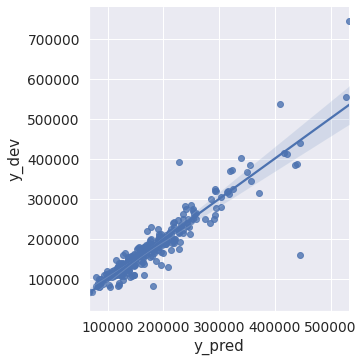

In [ ]:
pred_rf = pd.DataFrame({'y_dev': y_dev, 'y_pred': predictions})
sns.lmplot(x='y_pred',y = 'y_dev',data=pred_rf)

The scatter plot of y_pred versus y_dev shows a pretty tight distribution of data points around the mean line which is quite well aligned with the 1:1 line indicating little bias in the mean prediction. There are four outliers that worth a closer look.

In [ ]:
print(pred_rf[pred_rf['y_pred']>390000])

       y_dev     y_pred
1182  745000  533500.35
161   412500  421596.95
224   386250  440227.04
278   415298  416761.32
58    438780  444809.50
769   538000  409266.37
1298  160000  445827.92
825   385000  436947.70
440   555000  528443.90


In [ ]:
print(pred_rf[pred_rf['y_dev']>390000])

       y_dev     y_pred
1182  745000  533500.35
231   403000  338907.66
161   412500  421596.95
688   392000  229044.33
278   415298  416761.32
58    438780  444809.50
769   538000  409266.37
440   555000  528443.90


### A closer look at the 4 Outliers
Overestimate: 

ID=1298, SF=1619, Sale Type=New, Sale Condition=Partial, Bldg Type=TwnhsE, YearBuilt=2005, MSZoning=RM,

Underestimate: 

ID=1182, SF=3152, Sale Type-New, Sale Condition=Partial, Bldg Type=TwnhsE, YearBuilt=2008, MSZoning=RM,

ID=769, SF=1860, Bldg Type=1Fam, YearBuilt=2004, MSZoning=RL,                
                
ID=688, SF=1341, Bldg Type=TwnhsE, YearBuilt=2004, MSZoning=FV

An interesting observation about the four outliers is that all four are relatively newly built houses from 2004 to 2008. Three of the houses are over priced relative to the model prediction. This is consistent with the housing market bubble occuring in that time frame nationwide. The one house that is under priced also has a 'Partial' Sale Condition which may indicate that the house was not fully finished (priced) at the time of transaction. This is purely speculation at this point since the same sale condition is true for house ID 1182 but that one is over priced. In any case, there may very well be unique circumstances for these outliers that are not captured by the model. The same four outliers are visible too in the XGB scatter plot below with slightly less scattering.

In [ ]:
all_df[all_df['Id'].isin([1182,1298,769,688])].T

,439,687,768,1181,1297
Id,440,688,769,1182,1298
MSSubClass,50,160,20,120,180
MSZoning,RL,FV,RL,RM,RM
LotFrontage,67,61.2769,70,64,35
LotArea,12354,5105,9100,5587,3675
...,...,...,...,...,...
haspool,0,0,0,0,0
has2ndfloor,1,1,0,0,0
hasgarage,1,1,1,1,1
hasbsmt,1,1,1,1,1


### The Scatter Plot of the XGB Prediction versus Actual Sale Prices and the Histogram of Error Residuals

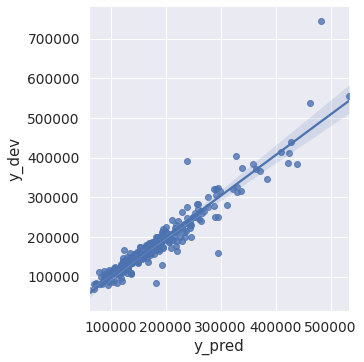

In [ ]:
pred_xgb = pd.DataFrame({'y_dev': y_dev, 'y_pred': predictions_xgb})
sns.lmplot(x='y_pred',y = 'y_dev',data=pred_xgb)

# define the percent error for prediction and plot the histogram of the percent error distribution
pe_dis = pd.DataFrame({'y_dev': y_dev, 'pe': (predictions_xgb-y_dev)/predictions_xgb})

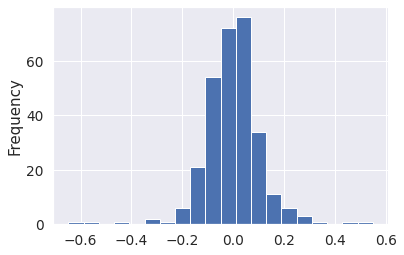

In [ ]:
ax = pe_dis['pe'].plot.hist(bins=20)

It is worth noting that the under priced house, ID 1298, is predicted to be a lot less expensive in XGB than in RF thus the prediction is somewhat closer to the actual price. A similar improvement in prediction can be observed for the over priced house, ID 769 (y_dev ~ 538k), the XGB prediction is higher than RF's and the data point moves to the right and gets closer to the mean prediction line. The residual histogram of the XGB predictor looks reasonably normal with a slight skew to the left or a slightly higher probability to under-predict. But the distribution is evenly centered around 0 and a majority of predictions are accurate within  ± 5%.

## Submission

In [ ]:
# Predict model results on test data
preds_test =  xgb.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
#submission_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')
#output.to_csv('submission.csv', index=False)
output

,Id,SalePrice
0,1461,126178.773438
1,1462,171087.046875
2,1463,184314.203125
3,1464,196681.500000
4,1465,183699.359375
...,...,...
1454,2915,79970.453125
1455,2916,80641.054688
1456,2917,165219.046875
1457,2918,113444.460938


## Conclusion

This has been a fun project to do and we have learned a lot from trials and errors.  Although we have not quite get to the state-of-the-art accuracy for our model, we did make significant imporvement from the baseline.  The baseline was a simple linear regression model which is a good reference because it was the standard method for house appraisal and it has been used in the real estate industry for years.  It is often referred to as the hedonic model which is defined as the sum of the valuation of major components of the house. It is easy to interpret and easy to understand, the only drawback is since there are many sources of variation and unmodelled variables, the hedonic model has a high bias and are typically not accurate within 15% of the real sale price in terms of MAPE (Mean Absolute Percent Error).  

Through meticulous feature engineering and painstaking data mining, we have obtained a reasonably clean and reliable dataset to work with.  By exploring a wide variety of advanced machine learning and regression methods, we are able to identify the best regression models for this data. In this case, they are random forest and two gradient boosting methods (GBR and XGB). We originally expect the ensemble of the three models should complement each other's weaknesses and strengths to make the combined model more accurate than each one alone.  But we are surprised to find out XGB alone performed the best.  In terms of MAPE, the XGB model achieves 8.3% compared to 15.7% of the baseline.  The ensemble model of RF+GBR+XGB is not far behind at 8.4% MAPE.  We understand that this is still far from the state-of-the-art (Zillow has claimed a MAPE of 6.9%), but we don't have the benefits of a broader sets of meta-data, historical information and additional interior photos and satellite neighborhood images that Zillow could leverage.  

A challenge in applying advanced machine learning methods to house price prediction is the ability to interpret the model is lost for these advanced methods.  We have tried to look beyond a few metrics of performance, dug deeper into the outliers and provided meaningful insights, but these unique circumstances may or may not be generalizable in statistically significant manner due to limited number of available samples. Keeping these limitations in mind, if better model accuracy is desired, we believe that the advanced machine learning models developed here can be used as the basis for incorporating additional text information from advertisement or web search to better understand the market dynamics, interior photos to better determine the quality level of the property, and satellite images to better represent the desirability of a particular location.  